# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
import tensorflow as tf
from utils import get_dataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

2021-10-02 14:55:32.382276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# FILENAME = '/data/waymo/segment-11940460932056521663_1760_000_1780_000_with_camera_labels.tfrecord'
FILENAME = '/data/waymo/preprocessed/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'
# FILENAME = '/data/waymo/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord'

dataset = get_dataset(FILENAME)

INFO:tensorflow:Reading unweighted datasets: ['/data/waymo/preprocessed/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/data/waymo/preprocessed/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2021-10-02 14:55:34.401278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 14:55:34.401357: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 14:55:34.401392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-U99550S): /proc/driver/nvidia/version does not exist
2021-10-02 14:55:34.401868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    # ADD CODE HERE
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    
    rows = (batch+1) // 2
    fig, axis = plt.subplots(rows, 2, figsize=(50,50))
    
    for example, ax in zip(dataset.shuffle(buffer_size=1000).take(batch), axis.flat):
        
        image, boxes, labels = example['image'].numpy(), example['groundtruth_boxes'].numpy(), example['groundtruth_classes'].numpy()
        height, width, _ = image.shape

        # [ymin, xmin, ymax, xmax] 
        boxes[:,0] = boxes[:,0] * height
        boxes[:,2] = boxes[:,2] * height
        boxes[:,1] = boxes[:,1] * width
        boxes[:,3] = boxes[:,3] * width
        
        ax.imshow(image)
        ax.grid(False)
        ax.axis('off')
        
        for box, label in zip(boxes, labels):  
            ax.add_patch(patches.Rectangle(
                            xy=(box[1],box[0]),
                            width=box[3]-box[1],
                            height=box[2]-box[0],
                            linewidth=1,
                            edgecolor=colormap[label],
                            facecolor='none'))
    
    fig.tight_layout()
    fig.show()        

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

2021-10-02 14:55:42.882338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-02 14:55:42.887191: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2095985000 Hz


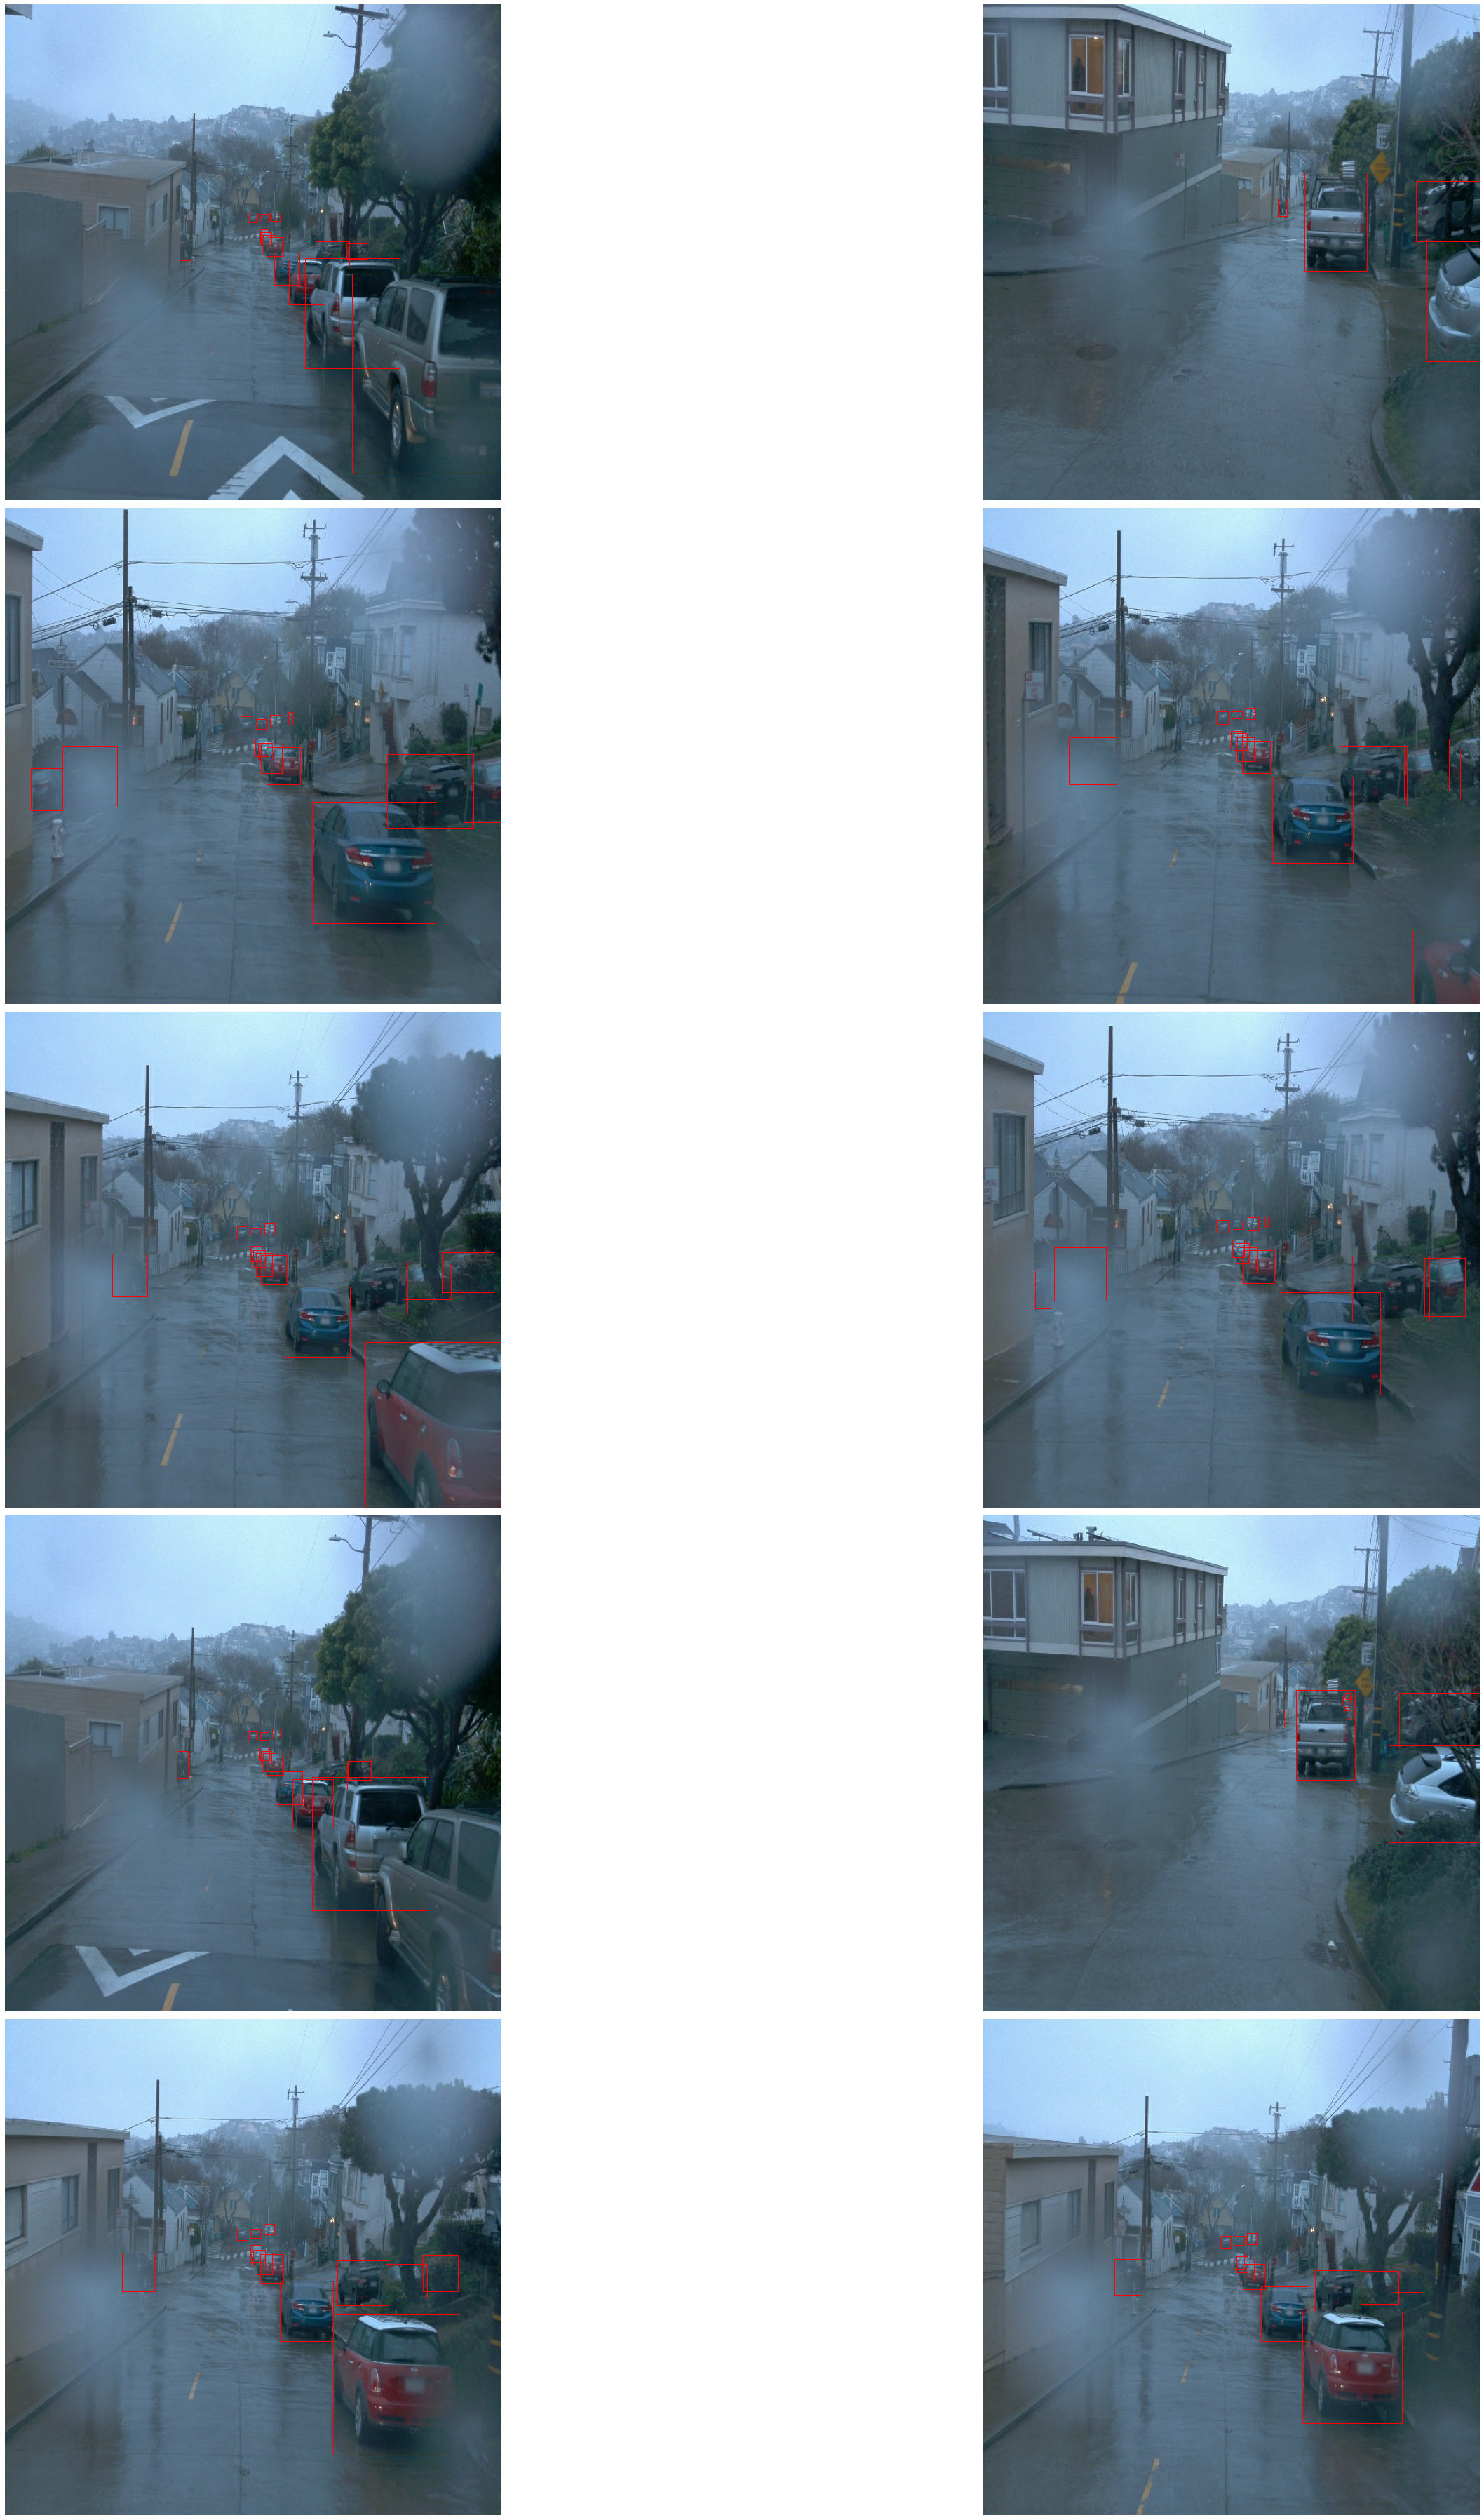

In [4]:
## STUDENT SOLUTION HERE
display_instances(10)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### Object Type Distribution

In [5]:
import glob

def display_distribution():
    n_vehicle, n_pedestrian, n_cyclist = 0, 0, 0
    for i, dataset_file_path in enumerate(glob.glob('/data/waymo/preprocessed/segment*'),1):
        print(i, dataset_file_path)
        dataset = get_dataset(dataset_file_path).repeat(1)
#         dataset = dataset.apply(tf.contrib.data.unbatch())
#         dataset = dataset.batch(10000)
#         print(type(dataset))
#         print(len(list(dataset)))
        for example in dataset.take(100000):
            labels = example['groundtruth_classes'].numpy()
#             print(labels)
            for label in labels:  
                if label == 1:
                    n_vehicle += 1
                elif label == 2:
                    n_pedestrian += 1
                elif label == 4:
                    n_cyclist += 1
                else:
                    raise Exception('an incorrect label type : {}'.format(label))
    
    print('the count of vehicles = {}'.format(n_vehicle))
    print('the count of pedestrians = {}'.format(n_pedestrian))
    print('the count of cyclists = {}'.format(n_cyclist))    
    
    plt.figure(figsize=(5,5))
    plt.bar(['vehicle','pedestrian','cyclist'], [n_vehicle, n_pedestrian, n_cyclist], color = ['orange','blue','green'])
    plt.xlabel('Object Type')
    plt.ylabel('count')
    plt.show()

In [ ]:
display_distribution()

**Conclusion**
- Our training dataset has the lack of pedestrian samples and cyclist samples.  
- Especially, the count of cyclist samples is zero.
- Our model might not dectect pedestrians and cyclists